# Step 3 — Candidate Generation

**CSAO Rail Recommendation System · Zomathon Hackathon**

Pre-computed item embeddings (Sentence Transformers `all-MiniLM-L6-v2`) + exact dot product search via numpy.

| Component | Detail |
|-----------|--------|
| **Offline** | Encode every menu item once, save embeddings to disk |
| **Runtime** | Mean-pool cart embeddings into query vector, dot product against filtered candidates, take top 50 |
| **Scale** | 30–80 candidates after hard filters — exact search faster than FAISS at this size |

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from hard_filters import HardFilterPipeline
from candidate_generation import CandidateGenerator, generate_and_save_embeddings

DATA = "../data"
EMBEDDINGS_PATH = f"{DATA}/item_embeddings.npz"

restaurants = pd.read_csv(f"{DATA}/restaurants.csv")
menu        = pd.read_csv(f"{DATA}/menu_items.csv")
users       = pd.read_csv(f"{DATA}/users.csv")
sessions    = pd.read_csv(f"{DATA}/sessions.csv")
events      = pd.read_csv(f"{DATA}/cart_events.csv")

pipe = HardFilterPipeline(menu, restaurants, users)
cgen = CandidateGenerator(EMBEDDINGS_PATH)

print(f"Menu items   : {len(menu):>6,}")
print(f"Sessions     : {len(sessions):>6,}")
print(f"Embeddings   : {cgen.n_items:>6,} items x {cgen.dim} dims")
print("Pipeline loaded.")

Menu items   :  2,037
Sessions     : 15,000
Embeddings   :  2,037 items x 384 dims
Pipeline loaded.


In [2]:
# Pre-compute cart items per session (fast groupby instead of per-row filtering)
_cart_events = events[events["cart_position"].notna()]
_cart_by_session = _cart_events.groupby("session_id")["item_id"].apply(set).to_dict()

def get_cart_items(session_id):
    """Return the set of item_ids in a session's cart."""
    return _cart_by_session.get(session_id, set())

def get_cart_df(cart_ids):
    """Return menu rows for items in the cart."""
    return menu[menu["item_id"].isin(cart_ids)]

_rest_cuisine = dict(zip(restaurants["restaurant_id"], restaurants["primary_cuisine"]))

def get_restaurant_cuisine(restaurant_id):
    """Look up a restaurant's primary cuisine."""
    return _rest_cuisine.get(restaurant_id)

---
## 1. Embedding Inspection

Verify the pre-computed embeddings: shape, normalization, and basic statistics.

In [3]:
data = np.load(EMBEDDINGS_PATH, allow_pickle=True)
embeddings = data["embeddings"]
item_ids = data["item_ids"]

norms = np.linalg.norm(embeddings, axis=1)

print("=== Embedding Summary ===")
print(f"  Shape          : {embeddings.shape}")
print(f"  Dtype          : {embeddings.dtype}")
print(f"  L2 norm range  : [{norms.min():.6f}, {norms.max():.6f}]")
print(f"  L2 norm mean   : {norms.mean():.6f}")
print(f"  File size      : {os.path.getsize(EMBEDDINGS_PATH) / 1024:.0f} KB")
print()

mean_vec = embeddings.mean(axis=0)
print(f"  Mean vector norm : {np.linalg.norm(mean_vec):.4f}")
print(f"  Variance per dim : {embeddings.var(axis=0).mean():.6f}")

=== Embedding Summary ===
  Shape          : (2037, 384)
  Dtype          : float32
  L2 norm range  : [1.000000, 1.000000]
  L2 norm mean   : 1.000000
  File size      : 2676 KB

  Mean vector norm : 0.5813
  Variance per dim : 0.001724


---
## 2. Embedding Space Visualization

PCA and t-SNE projections of all item embeddings, colored by cuisine and category.

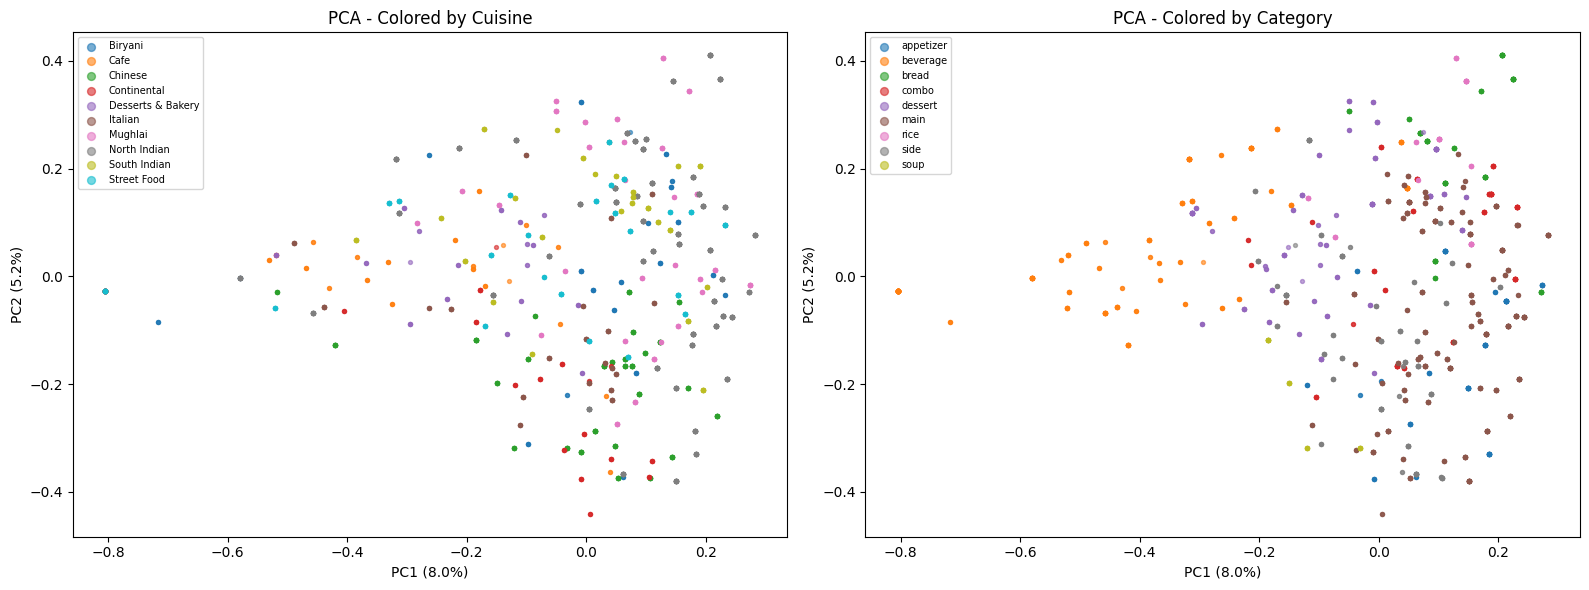

In [4]:
# Map item_ids back to menu metadata for coloring
id_to_idx = {iid: i for i, iid in enumerate(item_ids)}
emb_cuisine = menu["item_id"].map(lambda x: menu.loc[menu["item_id"] == x, "cuisine_tag"].values[0] if x in id_to_idx else None)

# Faster lookup
cuisine_map = dict(zip(menu["item_id"], menu["cuisine_tag"]))
category_map = dict(zip(menu["item_id"], menu["category"]))
cuisines = np.array([cuisine_map.get(iid, "Unknown") for iid in item_ids])
categories = np.array([category_map.get(iid, "Unknown") for iid in item_ids])

# PCA (fast, for structure overview)
pca = PCA(n_components=2, random_state=42)
emb_2d_pca = pca.fit_transform(embeddings)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# By cuisine
ax = axes[0]
unique_cuisines = sorted(set(cuisines))
for cuisine in unique_cuisines:
    mask = cuisines == cuisine
    ax.scatter(emb_2d_pca[mask, 0], emb_2d_pca[mask, 1], s=8, alpha=0.6, label=cuisine)
ax.set_title("PCA - Colored by Cuisine")
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
ax.legend(fontsize=7, markerscale=2, loc="best")

# By category
ax2 = axes[1]
unique_cats = sorted(set(categories))
for cat in unique_cats:
    mask = categories == cat
    ax2.scatter(emb_2d_pca[mask, 0], emb_2d_pca[mask, 1], s=8, alpha=0.6, label=cat)
ax2.set_title("PCA - Colored by Category")
ax2.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
ax2.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
ax2.legend(fontsize=7, markerscale=2, loc="best")

plt.tight_layout()
plt.show()

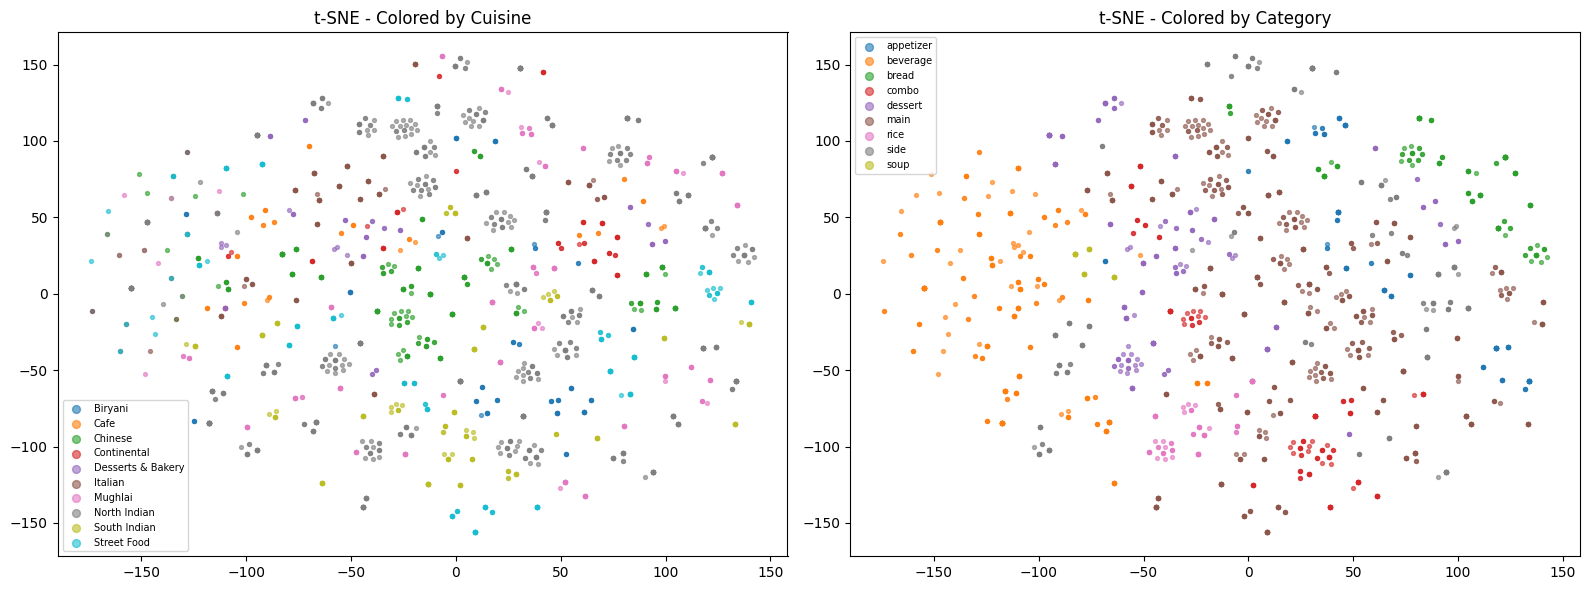

In [5]:
# t-SNE (higher quality non-linear projection, slower)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
emb_2d_tsne = tsne.fit_transform(embeddings)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
for cuisine in unique_cuisines:
    mask = cuisines == cuisine
    ax.scatter(emb_2d_tsne[mask, 0], emb_2d_tsne[mask, 1], s=8, alpha=0.6, label=cuisine)
ax.set_title("t-SNE - Colored by Cuisine")
ax.legend(fontsize=7, markerscale=2, loc="best")

ax2 = axes[1]
for cat in unique_cats:
    mask = categories == cat
    ax2.scatter(emb_2d_tsne[mask, 0], emb_2d_tsne[mask, 1], s=8, alpha=0.6, label=cat)
ax2.set_title("t-SNE - Colored by Category")
ax2.legend(fontsize=7, markerscale=2, loc="best")

plt.tight_layout()
plt.show()

---
## 3. Single Session Walkthrough

Full pipeline: Step 2 hard filters -> Step 3 candidate generation -> ranked top 50.

In [6]:
# Pick a session with a reasonable cart size (2-4 items)
_session_cart_sizes = {sid: len(ids) for sid, ids in _cart_by_session.items()}
sessions["cart_size"] = sessions["session_id"].map(_session_cart_sizes).fillna(0).astype(int)
good_sessions = sessions[(sessions["cart_size"] >= 2) & (sessions["cart_size"] <= 4)]
sample_session = good_sessions.iloc[0]

sid = sample_session["session_id"]
rid = sample_session["restaurant_id"]
uid = sample_session["user_id"]
cuisine = get_restaurant_cuisine(rid)

cart_ids = get_cart_items(sid)
cart_df = get_cart_df(cart_ids)

print(f"=== Session {sid} ===")
print(f"  Restaurant : {rid} ({cuisine})")
print(f"  User       : {uid} (segment: {users[users['user_id']==uid].iloc[0]['segment']})")
print(f"  Toggle     : {sample_session['dietary_toggle']}")
print(f"  Cart ({len(cart_ids)} items):")
for _, item in cart_df.iterrows():
    veg = "V" if item["veg_flag"] else "NV"
    print(f"    {item['item_id']}  {item['name']:<35} Rs {item['price']:>4}  [{veg}] {item['category']}")

=== Session S000001 ===
  Restaurant : R0015 (North Indian)
  User       : U02599 (segment: Occasional)
  Toggle     : none
  Cart (4 items):
    I00319  Chicken Tikka Masala                Rs  355  [NV] main
    I00321  Chole Masala                        Rs  197  [V] main
    I00335  Masala Chaas                        Rs   46  [V] beverage
    I00340  Gulab Jamun (2 Pcs)                 Rs   97  [V] dessert


In [7]:
# Step 2: Hard filters
filtered_df, flog = pipe.run_filters(
    restaurant_id=rid,
    user_id=uid,
    session_start=sample_session["start_time"],
    dietary_toggle=sample_session["dietary_toggle"],
    cart_item_ids=cart_ids,
)

print(f"=== Hard Filter Funnel ===")
print(f"  Initial menu   : {flog['initial']}")
print(f"  After Filter A : {flog['after_A']}  (availability & margin)")
print(f"  After Filter B : {flog['after_B']}  (dietary)")
print(f"  After Filter C : {flog['after_C']}  (cuisine coherence)")
print(f"  After Filter D : {flog['after_D']}  (quantity saturation)")
print(f"  After Filter E : {flog['after_E']}  (dedup & fatigue)")
print(f"\n  Candidates for Step 3: {len(filtered_df)}")

=== Hard Filter Funnel ===
  Initial menu   : 29
  After Filter A : 27  (availability & margin)
  After Filter B : 27  (dietary)
  After Filter C : 27  (cuisine coherence)
  After Filter D : 27  (quantity saturation)
  After Filter E : 23  (dedup & fatigue)

  Candidates for Step 3: 23


In [8]:
# Step 3: Candidate generation
top_candidates = cgen.generate_candidates(
    cart_item_ids=cart_ids,
    filtered_candidates_df=filtered_df,
    restaurant_cuisine=cuisine,
    top_k=50,
)

print(f"=== Top Candidates (showing top 15 of {len(top_candidates)}) ===")
print(f"{'Rank':<5} {'Score':<7} {'Item':<35} {'Cat':<12} {'Subcat':<15} {'Price':>6} {'VF':<3}")
print("-" * 90)
for rank, (_, row) in enumerate(top_candidates.head(15).iterrows(), 1):
    vf = "V" if row["veg_flag"] else "NV"
    print(f"{rank:<5} {row['similarity_score']:.4f}  {row['name']:<35} {row['category']:<12} {row['subcategory']:<15} Rs {row['price']:>4}  {vf}")

print(f"\n  Score range: [{top_candidates['similarity_score'].min():.4f}, {top_candidates['similarity_score'].max():.4f}]")
print(f"  Categories in top 50: {dict(top_candidates['category'].value_counts())}")

=== Top Candidates (showing top 15 of 23) ===
Rank  Score   Item                                Cat          Subcat           Price VF 
------------------------------------------------------------------------------------------
1     0.6404  Malai Kofta                         main         curry           Rs  302  V
2     0.6170  Butter Chicken Meal                 combo        meal_combo      Rs  344  NV
3     0.6122  Kadai Chicken                       main         curry           Rs  325  NV
4     0.6083  Butter Chicken                      main         curry           Rs  279  NV
5     0.5898  Palak Paneer                        main         curry           Rs  210  V
6     0.5603  Jeera Rice                          rice         rice            Rs  165  V
7     0.5598  Egg Curry                           main         curry           Rs  201  NV
8     0.5458  Tandoori Chicken Half               appetizer    tandoori        Rs  230  NV
9     0.5431  Veg Pulao                         

---
## 4. Edge Cases

### 4a. Empty Cart (Cold Start)
No items in cart — query vector falls back to restaurant cuisine name.

In [9]:
# Empty cart — cold start fallback
cold_rest = restaurants[restaurants["primary_cuisine"] == "Chinese"].iloc[0]
cold_rid = cold_rest["restaurant_id"]
cold_cuisine = cold_rest["primary_cuisine"]

cold_menu = menu[
    (menu["restaurant_id"] == cold_rid)
    & (menu["availability"])
    & (menu["margin_pct"] >= 10)
]

cold_candidates = cgen.generate_candidates(
    cart_item_ids=[],
    filtered_candidates_df=cold_menu,
    restaurant_cuisine=cold_cuisine,
    top_k=10,
)

print(f"=== Cold Start: Empty Cart at {cold_rid} ({cold_cuisine}) ===")
print(f"  Available items: {len(cold_menu)}")
print(f"\n  Top 10 recommendations:")
for rank, (_, row) in enumerate(cold_candidates.iterrows(), 1):
    print(f"    {rank:>2}. {row['similarity_score']:.4f}  {row['name']:<35} [{row['category']}]")

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


=== Cold Start: Empty Cart at R0011 (Chinese) ===
  Available items: 15

  Top 10 recommendations:
     1. 0.4774  Chinese Combo for 1                 [combo]
     2. 0.4029  Chicken Manchurian                  [main]
     3. 0.3572  Kung Pao Chicken                    [main]
     4. 0.3570  Chinese Feast for 2                 [combo]
     5. 0.3453  Dragon Chicken                      [main]
     6. 0.3342  Chicken Fried Rice                  [main]
     7. 0.2987  Iced Lemon Tea                      [beverage]
     8. 0.2911  Chilli Chicken                      [main]
     9. 0.2193  Chicken Momos (6 Pcs)               [side]
    10. 0.2192  Fresh Lime Soda                     [beverage]


### 4b. Veg-Only Session
Session with veg toggle — hard filter removes non-veg first, then embeddings rank the remainder.

In [ ]:
# Veg-only session
veg_sessions = sessions[sessions["dietary_toggle"] == "veg"]
vs = veg_sessions.iloc[0]

vs_cart = get_cart_items(vs["session_id"])
vs_cuisine = get_restaurant_cuisine(vs["restaurant_id"])

vs_filtered, vs_flog = pipe.run_filters(
    restaurant_id=vs["restaurant_id"],
    user_id=vs["user_id"],
    session_start=vs["start_time"],
    dietary_toggle="veg",
    cart_item_ids=vs_cart,
)

vs_candidates = cgen.generate_candidates(
    cart_item_ids=vs_cart,
    filtered_candidates_df=vs_filtered,
    restaurant_cuisine=vs_cuisine,
    top_k=20,
)

print(f"=== Veg Session {vs['session_id']} ===")
print(f"  Restaurant: {vs['restaurant_id']} ({vs_cuisine})")
print(f"  Cart: {list(get_cart_df(vs_cart)['name'].values)}")
print(f"  Candidates after hard filters: {len(vs_filtered)}")
print(f"  Non-veg in candidates: {(~vs_filtered['veg_flag']).sum()}  (should be 0)")
print(f"\n  Top 10:")
for rank, (_, row) in enumerate(vs_candidates.head(10).iterrows(), 1):
    print(f"    {rank:>2}. {row['similarity_score']:.4f}  {row['name']:<35} [{'V' if row['veg_flag'] else 'NV'}]")

### 4c. Combo/Thali in Cart
When a combo is in the cart, hard filters suppress its component subcategories. Embedding search then ranks what remains.

In [ ]:
# Find a session-like scenario with a combo in cart
combos = menu[(menu["is_combo"]) & (menu["subcategory"].isin(["thali", "meal_combo"]))]
sample_combo = combos.iloc[0]
combo_rid = sample_combo["restaurant_id"]
combo_cuisine = get_restaurant_cuisine(combo_rid)

# Simulate a cart with just the combo
combo_cart = {sample_combo["item_id"]}
combo_filtered, combo_flog = pipe.run_filters(
    restaurant_id=combo_rid,
    user_id=users.iloc[0]["user_id"],
    session_start="2025-12-15T12:30:00",
    dietary_toggle="none",
    cart_item_ids=combo_cart,
)

combo_candidates = cgen.generate_candidates(
    cart_item_ids=combo_cart,
    filtered_candidates_df=combo_filtered,
    restaurant_cuisine=combo_cuisine,
    top_k=15,
)

components = json.loads(sample_combo["combo_components"])
print(f"=== Combo in Cart ===")
print(f"  Combo: {sample_combo['name']} ({sample_combo['subcategory']})")
print(f"  Components: {components}")
print(f"  Suppressed subcats: {combo_flog['log_C'].get('combo_suppressed_subcats', 'none')}")
print(f"  Candidates after filters: {len(combo_filtered)}")
print(f"\n  Top 10 add-on suggestions:")
for rank, (_, row) in enumerate(combo_candidates.head(10).iterrows(), 1):
    print(f"    {rank:>2}. {row['similarity_score']:.4f}  {row['name']:<35} [{row['subcategory']}]")

---
## 5. Batch Analysis — 100 Sessions

Run the full Step 2 + Step 3 pipeline on 100 random sessions. Analyze candidate pool sizes, score distributions, and latency.

In [ ]:
import time

np.random.seed(42)
sample_sessions = sessions.sample(100, random_state=42)

batch_records = []
for _, s in sample_sessions.iterrows():
    cart_ids = get_cart_items(s["session_id"])
    cuisine = get_restaurant_cuisine(s["restaurant_id"])

    try:
        # Step 2
        filtered, flog = pipe.run_filters(
            restaurant_id=s["restaurant_id"],
            user_id=s["user_id"],
            session_start=s["start_time"],
            dietary_toggle=s["dietary_toggle"],
            cart_item_ids=cart_ids,
        )

        # Step 3 (timed)
        t0 = time.perf_counter()
        candidates = cgen.generate_candidates(
            cart_item_ids=cart_ids,
            filtered_candidates_df=filtered,
            restaurant_cuisine=cuisine,
            top_k=50,
        )
        step3_ms = (time.perf_counter() - t0) * 1000

        batch_records.append({
            "session_id": s["session_id"],
            "cart_size": len(cart_ids),
            "after_filters": len(filtered),
            "after_step3": len(candidates),
            "top_score": candidates["similarity_score"].max() if len(candidates) > 0 else 0,
            "median_score": candidates["similarity_score"].median() if len(candidates) > 0 else 0,
            "min_score": candidates["similarity_score"].min() if len(candidates) > 0 else 0,
            "step3_ms": step3_ms,
        })
    except Exception:
        pass

batch_df = pd.DataFrame(batch_records)
print(f"Successfully processed {len(batch_df)} / 100 sessions")
print()
print("=== Candidate Pool Sizes ===")
print(f"  After hard filters  : {batch_df['after_filters'].mean():.1f} avg  (range: {batch_df['after_filters'].min()}-{batch_df['after_filters'].max()})")
print(f"  After Step 3 top-50 : {batch_df['after_step3'].mean():.1f} avg  (range: {batch_df['after_step3'].min()}-{batch_df['after_step3'].max()})")
print()
print("=== Similarity Scores ===")
print(f"  Top score    : {batch_df['top_score'].mean():.4f} avg  (range: {batch_df['top_score'].min():.4f}-{batch_df['top_score'].max():.4f})")
print(f"  Median score : {batch_df['median_score'].mean():.4f} avg")
print(f"  Min score    : {batch_df['min_score'].mean():.4f} avg")
print()
print("=== Step 3 Latency ===")
print(f"  Mean   : {batch_df['step3_ms'].mean():.2f} ms")
print(f"  Median : {batch_df['step3_ms'].median():.2f} ms")
print(f"  p95    : {batch_df['step3_ms'].quantile(0.95):.2f} ms")
print(f"  Max    : {batch_df['step3_ms'].max():.2f} ms")

---
## 6. Visualizations

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Score distribution across all sessions
ax = axes[0, 0]
ax.hist(batch_df["top_score"], bins=20, alpha=0.7, color="#4C72B0", edgecolor="white", label="Top score")
ax.hist(batch_df["median_score"], bins=20, alpha=0.7, color="#55A868", edgecolor="white", label="Median score")
ax.set_xlabel("Similarity Score")
ax.set_ylabel("Sessions")
ax.set_title("Score Distribution Across 100 Sessions")
ax.legend()

# 2. Candidate pool size: after filters vs after top-50
ax = axes[0, 1]
ax.scatter(batch_df["after_filters"], batch_df["after_step3"], alpha=0.6, s=30, color="#C44E52")
ax.plot([0, batch_df["after_filters"].max()], [0, batch_df["after_filters"].max()],
        "--", color="gray", alpha=0.5, label="y = x (no reduction)")
ax.set_xlabel("Candidates After Hard Filters")
ax.set_ylabel("Candidates After Step 3 (top-50)")
ax.set_title("Pool Size: Hard Filters vs Step 3")
ax.legend()

# 3. Step 3 latency distribution
ax = axes[1, 0]
ax.hist(batch_df["step3_ms"], bins=25, color="#8172B2", edgecolor="white", alpha=0.8)
ax.axvline(batch_df["step3_ms"].median(), color="#C44E52", linestyle="--", label=f"Median: {batch_df['step3_ms'].median():.2f} ms")
ax.axvline(batch_df["step3_ms"].quantile(0.95), color="#CCB974", linestyle="--", label=f"p95: {batch_df['step3_ms'].quantile(0.95):.2f} ms")
ax.set_xlabel("Latency (ms)")
ax.set_ylabel("Sessions")
ax.set_title("Step 3 Latency Distribution")
ax.legend()

# 4. Extended funnel: Initial -> After Filters -> After Step 3
ax = axes[1, 1]
# Re-run to get initial counts for the funnel
funnel_stages = ["Initial Menu", "After Hard Filters", "After Step 3 (top-50)"]
# For initial, we need to count restaurant menu sizes
initial_counts = []
for _, s in sample_sessions.head(len(batch_df)).iterrows():
    rest_menu_size = len(menu[menu["restaurant_id"] == s["restaurant_id"]])
    initial_counts.append(rest_menu_size)
initial_avg = np.mean(initial_counts)
filter_avg = batch_df["after_filters"].mean()
step3_avg = batch_df["after_step3"].mean()

funnel_vals = [initial_avg, filter_avg, step3_avg]
colors = ["#4C72B0", "#55A868", "#64B5CD"]
bars = ax.bar(funnel_stages, funnel_vals, color=colors, edgecolor="white", linewidth=0.5)
for bar, val in zip(bars, funnel_vals):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.3, f"{val:.1f}",
            ha="center", fontsize=10, fontweight="bold")
ax.set_ylabel("Avg Candidates")
ax.set_title("Full Funnel: Menu -> Filters -> Step 3")
ax.set_ylim(0, initial_avg * 1.2)

plt.tight_layout()
plt.show()

---
## Summary

In [ ]:
print("=" * 62)
print("  STEP 3 — CANDIDATE GENERATION SUMMARY")
print("=" * 62)
print()
print(f"  Embedding model  : all-MiniLM-L6-v2")
print(f"  Embedding dim    : {cgen.dim}")
print(f"  Items encoded    : {cgen.n_items}")
print(f"  Storage          : {os.path.getsize(EMBEDDINGS_PATH) / 1024:.0f} KB")
print()
print(f"  Avg filtered pool    : {batch_df['after_filters'].mean():.0f} items")
print(f"  Avg Step 3 output    : {batch_df['after_step3'].mean():.0f} items (top-50)")
print(f"  Avg top sim score    : {batch_df['top_score'].mean():.4f}")
print(f"  Avg median sim score : {batch_df['median_score'].mean():.4f}")
print()
print(f"  Step 3 latency (p50) : {batch_df['step3_ms'].median():.2f} ms")
print(f"  Step 3 latency (p95) : {batch_df['step3_ms'].quantile(0.95):.2f} ms")
print(f"  Well within < 1ms budget for dot product at this scale")
print()
print("  Ready for Step 4 (Feature Assembly)")
print("=" * 62)